In [5]:
import pandas as pd
from obspy import UTCDateTime

# Path to your file
file_path = "/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/data/raw/lognonne2003_table3_partial.csv"
file_path_new = "/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/data/raw/lognonne2003_table3_partial_new.csv"

# Read the CSV
df = pd.read_csv(file_path)

# Conversion function
def convert_to_utc(date_str, sec):
    year = int(date_str[:2])
    year += 1900 if year >= 70 else 2000
    month = int(date_str[2:4])
    day = int(date_str[4:6])
    hour = int(date_str[6:8])
    minute = int(date_str[8:10])
    second = float(sec)
    return UTCDateTime(year, month, day, hour, minute, second).isoformat()

# Add new column
df["starttime"] = df.apply(lambda row: convert_to_utc(str(row["Date_hour_min"]), row["Seconds"]), axis=1)

# Overwrite the same file (or change path to save as new)
df.to_csv(file_path_new, index=False)

print(f"CSV updated with 'starttime' column at {file_path_new}")


CSV updated with 'starttime' column at /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/data/raw/lognonne2003_table3_partial_new.csv


In [ ]:
lat_15 = 26.13174
lon_15 = 3.63803

/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


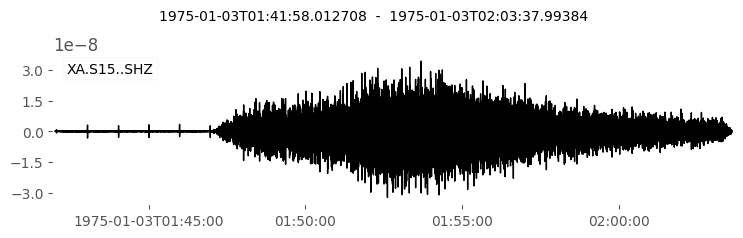

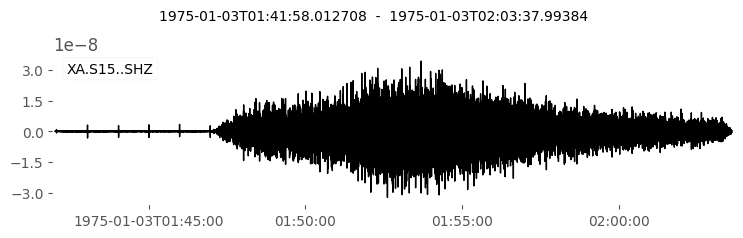

Sampling rate: 53.0 Hz


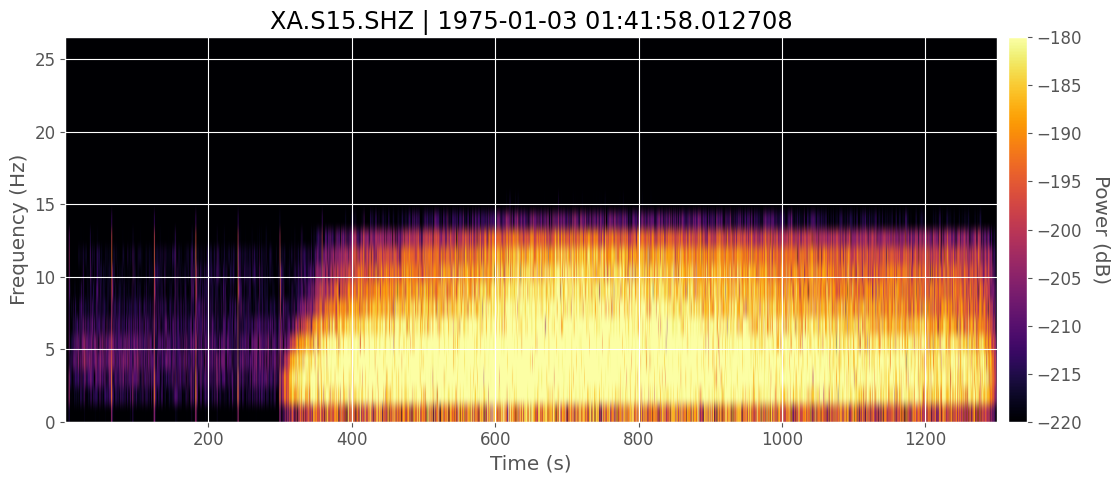

In [42]:
from heterogeneities.io import view_apollo, plot_spectrogram
from heterogeneities.processing import preprocess_trace, compute_spectrogram

trace = view_apollo(
        stream=None,
        starttime=UTCDateTime("1975-01-03T01:41:58"),
        endtime=UTCDateTime("1975-01-03T01:41:58") + 1300,
        network="XA",
        station="S15",
        channel="SHZ",
        location="*",
        plot_seismogram=False,
        plot_response=False,
    )   

trace.plot()
st= trace[0].copy()
preprocessed_trace = preprocess_trace(st)
preprocessed_trace.plot()
dB, extent, freqs, times = compute_spectrogram(st, window_sec=0.8, db_limits=[-290, -170])
plot_spectrogram(dB, extent, st, vmin=-220, vmax=-180, show = False)



In [143]:
R_moon = 1737.4
import numpy as np
df_time = pd.read_csv(file_path_new)

def latlon_depth_to_cartesian(lat, lon, depth):
    """
    Convert latitude (deg), longitude (deg), and depth (km below surface)
    into Cartesian coordinates centered at lunar center.
    """
    r = R_moon - depth
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    x = r * np.cos(lat_rad) * np.cos(lon_rad)
    y = r * np.cos(lat_rad) * np.sin(lon_rad)
    z = r * np.sin(lat_rad)
    return np.array([x, y, z])

# Apollo 15 seismometer coordinates (lat, lon, depth=0)
apollo15_lat = 26.132
apollo15_lon = 3.633
apollo15_depth = 0.0
apollo15_xyz = latlon_depth_to_cartesian(apollo15_lat, apollo15_lon, apollo15_depth)

apollo14_lat = -3.645
apollo14_lon = 342.552
apollo14_depth = 0.0
apollo14_xyz = latlon_depth_to_cartesian(apollo14_lat, apollo14_lon, apollo14_depth)

apollo16_lat = -8.976
apollo16_lon = 15.499
apollo16_depth = 0.0
apollo16_xyz = latlon_depth_to_cartesian(apollo16_lat, apollo16_lon, apollo16_depth)

# Compute hypocentral distances
df_time["hypo_dist_A14_km"] = df_time.apply(
    lambda row: np.linalg.norm(latlon_depth_to_cartesian(row["Lat"], row["Long"], row["Depth"]) - apollo14_xyz),
    axis=1
)
# Compute hypocentral distances
df_time["hypo_dist_A15_km"] = df_time.apply(
    lambda row: np.linalg.norm(latlon_depth_to_cartesian(row["Lat"], row["Long"], row["Depth"]) - apollo15_xyz),
    axis=1
)

df_time["hypo_dist_A16_km"] = df_time.apply(
    lambda row: np.linalg.norm(latlon_depth_to_cartesian(row["Lat"], row["Long"], row["Depth"]) - apollo16_xyz),
    axis=1
)

print(df_time[["Type", "Lat", "Long", "Depth", "hypo_dist_A14_km"]])
print(df_time[["Type", "Lat", "Long", "Depth", "hypo_dist_A15_km"]])
print(df_time[["Type", "Lat", "Long", "Depth", "hypo_dist_A16_km"]])

# Save updated file if needed
out_path = file_path.replace(".csv", "_with_dist.csv")
df_time.to_csv(out_path, index=False)
print(f"Updated CSV saved at: {out_path}")

  Type   Lat  Long  Depth  hypo_dist_A14_km
0   SH  48.0  38.2     10       2006.064996
1   SH  21.9  82.6      2       2673.455821
2   SH  26.1 -92.7      0       2197.412038
3   SH  64.1  59.9      0       2409.555374
4   SH -17.0 -26.1     21        475.919546
5   SH  44.1  34.0    125       1834.067257
6   SH  52.5 -25.8    185       1567.847422
  Type   Lat  Long  Depth  hypo_dist_A15_km
0   SH  48.0  38.2     10       1033.713725
1   SH  21.9  82.6      2       2019.467831
2   SH  26.1 -92.7      0       2324.698122
3   SH  64.1  59.9      0       1526.593559
4   SH -17.0 -26.1     21       1512.021300
5   SH  44.1  34.0    125        885.695444
6   SH  52.5 -25.8    185        987.908211
  Type   Lat  Long  Depth  hypo_dist_A16_km
0   SH  48.0  38.2     10       1743.149099
1   SH  21.9  82.6      2       2056.863977
2   SH  26.1 -92.7      0       2850.263247
3   SH  64.1  59.9      0       2241.305019
4   SH -17.0 -26.1     21       1216.386140
5   SH  44.1  34.0    125       

In [43]:
import pandas as pd

def read_lognonne_table(filepath: str) -> pd.DataFrame:
  
    try:
        df = pd.read_csv(filepath)
        return df
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

# Example usage:
file_path = "/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/data/raw/lognonne2003_table3_partial_with_dist.csv"
df = read_lognonne_table(file_path)

if df is not None:
    print(df.head())   # show first 5 rows
    print(df.columns)  # list all column names


  Type   Lat  Long  Depth  phi    a    b    c  Date_hour_min  Seconds  Error  \
0   SH  48.0  38.2     10   58  3.2  110  110     7212062308    33.40    7.4   
1   SH  21.9  82.6      2  -10  2.4   63   63     7407110046    18.26    1.3   
2   SH  26.1 -92.7      0   42  2.4   38   38     7501030141    58.36    6.8   
3   SH  64.1  59.9      0   59  1.8   14   14     7501120313    51.74    0.6   
4   SH -17.0 -26.1     21   44  3.0  112  112     7502132203    50.78    0.7   

                    starttime  hypo_dist_A15_km  
0  1972-12-06T23:08:33.400000       1033.713725  
1  1974-07-11T00:46:18.260000       2019.467831  
2  1975-01-03T01:41:58.360000       2324.698122  
3  1975-01-12T03:13:51.740000       1526.593559  
4  1975-02-13T22:03:50.780000       1512.021300  
Index(['Type', 'Lat', 'Long', 'Depth', 'phi', 'a', 'b', 'c', 'Date_hour_min',
       'Seconds', 'Error', 'starttime', 'hypo_dist_A15_km'],
      dtype='object')


In [140]:
from heterogeneities.processing import linear_interpolation, preprocess_trace, compute_spectrogram
import importlib
import heterogeneities.io
importlib.reload(heterogeneities.io)
import matplotlib.pyplot as plt
from heterogeneities.io import view_apollo, plot_spectrogram_title
from pathlib import Path

base_dir = Path("/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_SH_Lognonne")


for row in df.itertuples():
    trace = view_apollo(
        stream=None,
        starttime=UTCDateTime(row.starttime),
        endtime=UTCDateTime(row.starttime)+1300,
        network="XA",
        station="S15",
        channel="SHZ",
        location="*",
        plot_seismogram=False,
        plot_response=False,
    )
    tr = trace[0].copy()
    _ = linear_interpolation(tr)
    tr_processed = preprocess_trace(tr)
    # ---- build per-entry subfolder + filename stem
    stamp = tr.stats.starttime.strftime("%Y%m%dT%H%M%S")
    stem  = f"{tr.stats.network}.{tr.stats.station}.{tr.stats.channel}_{stamp}"
    out_dir = base_dir / stem
    out_dir.mkdir(parents=True, exist_ok=True)


    times = np.arange(len(tr_processed.data)) * tr_processed.stats.delta
    plt.style.use("default")   # reset to default (white background)
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(times, tr_processed.data * 1e9, linewidth=0.5, color="red")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Velocity (nm/s)")
    # Define hypocentral distance (assuming it's stored in the row)
    hypo_dist = getattr(row, "hypo_dist_A15_km", None)

    # Title
    title = (
        f"{tr.stats.network}.{tr.stats.station}.{tr.stats.channel} | "
        f"{tr.stats.starttime.strftime('%Y-%m-%d %H:%M:%S')}"
    )
    if hypo_dist is not None:
        title += f" | {hypo_dist:.1f} km"
    ax.set_title(title)
    ax.set_facecolor("white") 
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    seismo_path = out_dir / f"{stem}_seismogram.pdf"
    fig.savefig(seismo_path, dpi=300, bbox_inches="tight")
    plt.close(fig)  # 

    #print("Antes:", tr.data.mean(), tr.data.min(), tr.data.max())
    #print("Después:", tr_processed.data.mean(), tr_processed.data.min(), tr_processed.data.max())

    dB, extent, freqs, times = compute_spectrogram(tr_processed, window_sec=0.8, db_limits=None)
    ax = plot_spectrogram_title(dB, extent, tr_processed, vmin=-190, vmax=-150, show=False, hypo_dist=row.hypo_dist_A15_km)
    spec_path = out_dir / f"{stem}_spectrogram.pdf"
    plt.savefig(spec_path, dpi=300, bbox_inches="tight")
    plt.close()  

/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


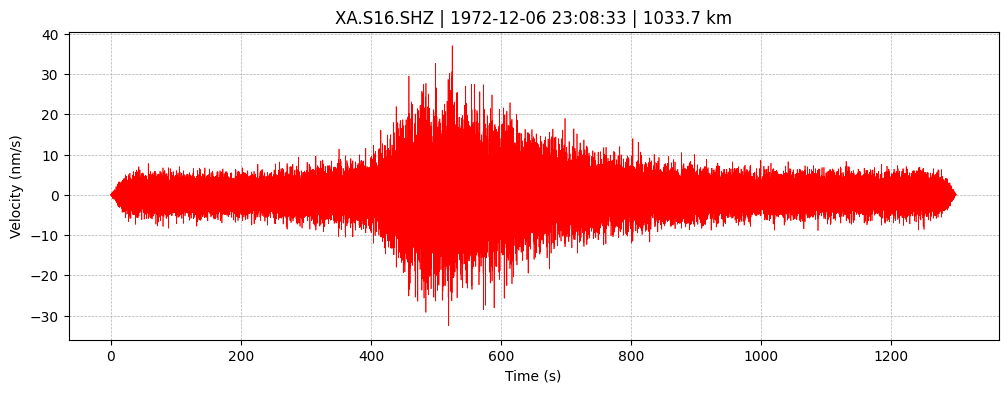

/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


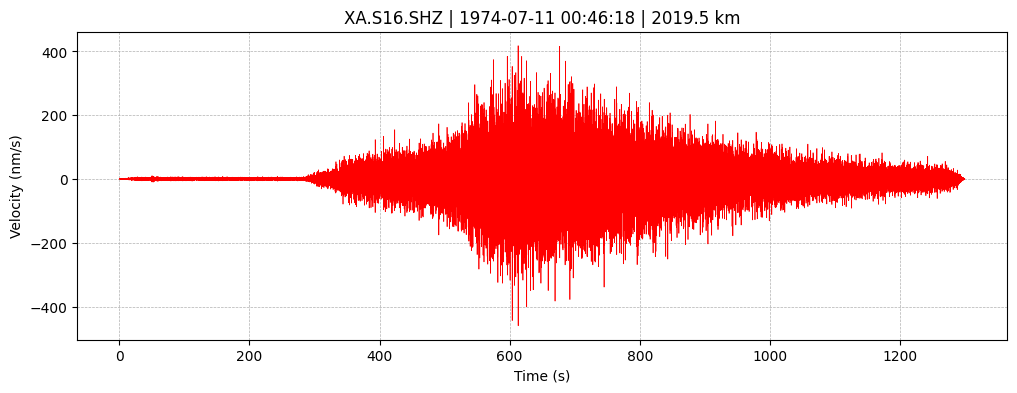

/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


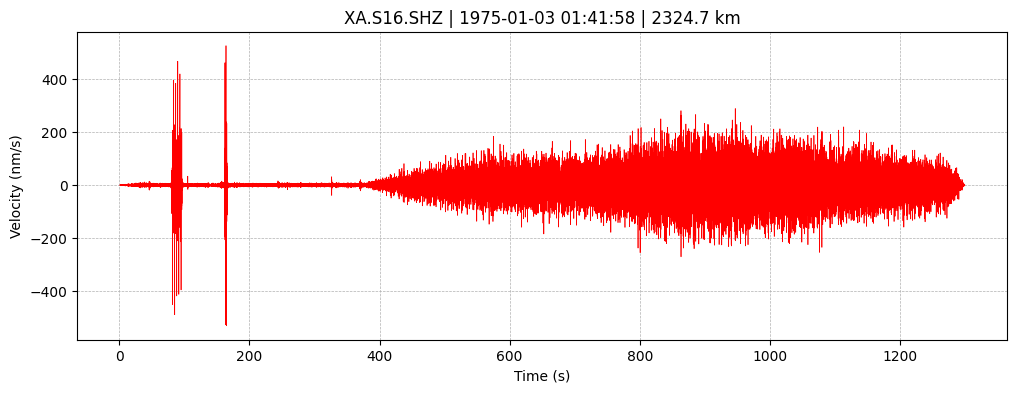

/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


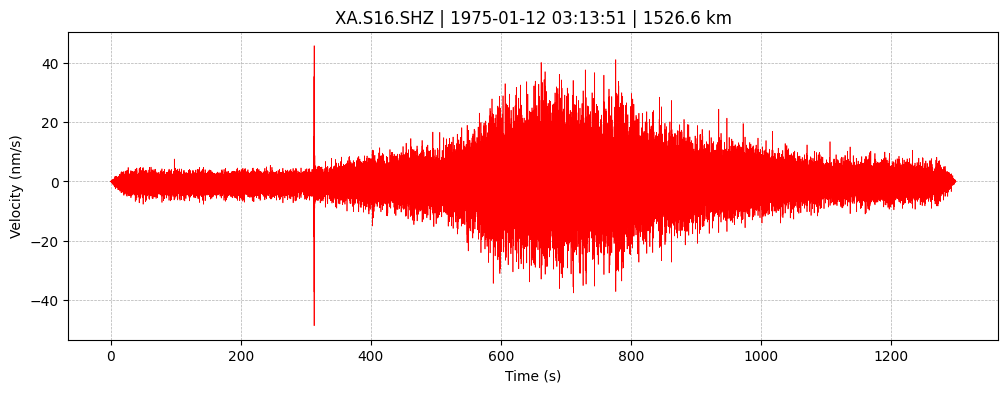

/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


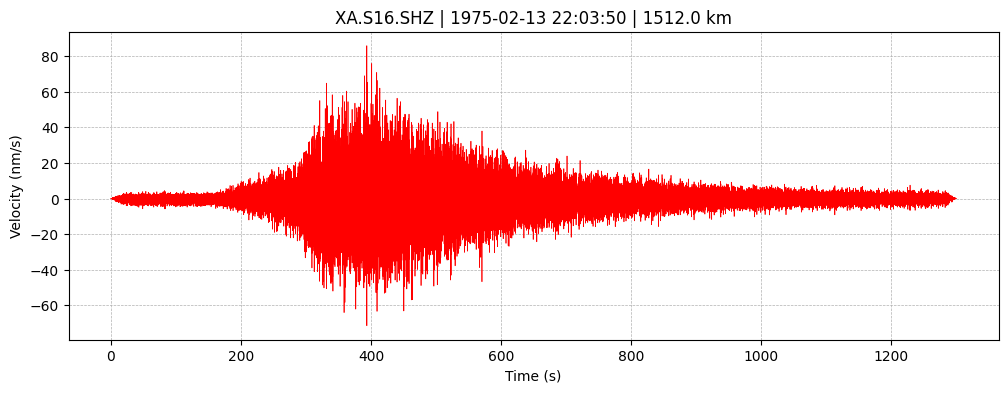

/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


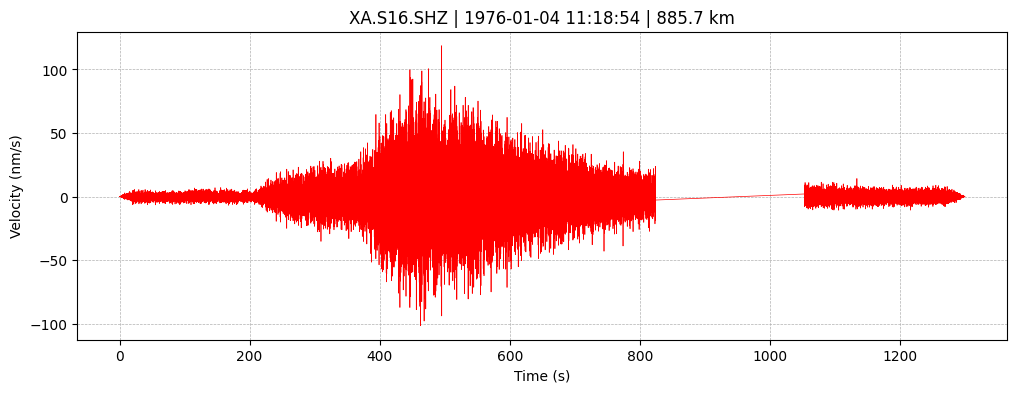

/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


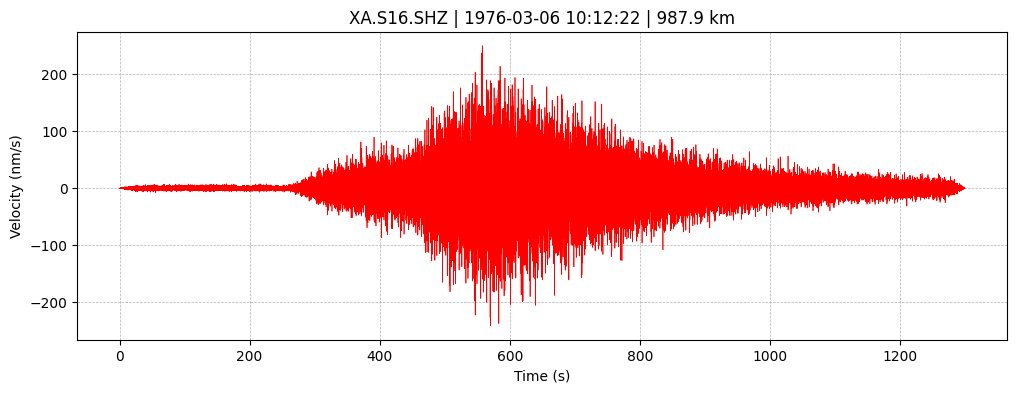

In [ ]:
file_path = "/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/data/raw/lognonne2003_table3_partial_with_dist_with_dist.csv"
df = read_lognonne_table(file_path)
for row in df.itertuples():
    trace = view_apollo(
        stream=None,
        starttime=UTCDateTime(row.starttime),
        endtime=UTCDateTime(row.starttime)+1300,
        network="XA",
        station="S16",#can be S14 S15 or S16
        channel="SHZ",
        location="*",
        plot_seismogram=False,
        plot_response=False,
    )
    tr = trace[0].copy()
    _ = linear_interpolation(tr)
    tr_processed = preprocess_trace(tr)
  

    times = np.arange(len(tr_processed.data)) * tr_processed.stats.delta
    plt.style.use("default")   # reset to default (white background)
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(times, tr_processed.data * 1e9, linewidth=0.5, color="red")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Velocity (nm/s)")
    # Here we have to better write the code to read the correct distance conlumn
    hypo_dist = getattr(row, "hypo_dist_A14_km", None)
    hypo_dist = getattr(row, "hypo_dist_A15_km", None)
    hypo_dist = getattr(row, "hypo_dist_A16_km", None)

    # Title
    title = (
        f"{tr.stats.network}.{tr.stats.station}.{tr.stats.channel} | "
        f"{tr.stats.starttime.strftime('%Y-%m-%d %H:%M:%S')}"
    )
    if hypo_dist is not None:
        title += f" | {hypo_dist:.1f} km"
    ax.set_title(title)
    ax.set_facecolor("white") 
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    seismo_path = out_dir / f"{stem}_seismogram.pdf"
    fig.savefig(seismo_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

    dB, extent, freqs, times = compute_spectrogram(tr_processed, window_sec=0.8, db_limits=None)
    #here agian we have to addapt the code to better read the correct distance column, not amanually just loop idk
    ax = plot_spectrogram_title(dB, extent, tr_processed, vmin=-190, vmax=-150, show=False, hypo_dist=row.hypo_dist_A14_km)
    ax = plot_spectrogram_title(dB, extent, tr_processed, vmin=-190, vmax=-150, show=False, hypo_dist=row.hypo_dist_A15_km)
    ax = plot_spectrogram_title(dB, extent, tr_processed, vmin=-190, vmax=-150, show=False, hypo_dist=row.hypo_dist_A16_km)
    spec_path = out_dir / f"{stem}_spectrogram.pdf"
    plt.savefig(spec_path, dpi=300, bbox_inches="tight")
    plt.close()  

In [181]:
import importlib
import heterogeneities.io
import heterogeneities.processing

importlib.reload(heterogeneities.io)
importlib.reload(heterogeneities.processing)

import matplotlib.pyplot as plt
from heterogeneities.io import view_apollo, plot_spectrogram_title
from pathlib import Path

from heterogeneities.processing import _latlon_depth_to_cartesian_vec, compute_and_save_hypo_distances
file_path_new = "/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/data/raw/Lognonne_DM.csv"
df_deep = pd.read_csv(file_path_new)

df_deep, out_path = compute_and_save_hypo_distances(
    df_deep,
    file_path_new,
    R_moon_km=1737.4,
    stations=None,
    out_suffix="_with_dist.csv"
)


In [185]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from obspy import UTCDateTime

# Station mapping between seismogram station codes (S14...) and Apollo codes (A14...)
STATION_TO_APOLLO = {"S14": "A14", "S15": "A15", "S16": "A16"}

def _safe_hypo_distance(row, station):
    """Pick the correct hypo distance column for this station, or return None."""
    apollo = STATION_TO_APOLLO.get(station)
    if not apollo:
        return None
    col = f"hypo_dist_{apollo}_km"
    return getattr(row, col, None)

def _event_folder_name(tr, apollo_code):
    """Folder name: XA.A*.SHZ_YYYYMMDDThhmmss"""
    t0 = tr.stats.starttime
    timestamp = t0.strftime("%Y%m%dT%H%M%S")
    return f"XA.{apollo_code}.SHZ_{timestamp}"

def batch_make_plots(
    file_path,
    out_root="plots",
    stations=("S14", "S15", "S16"),
    network="XA",
    channel="SHZ",
    location="*",
    duration_sec=1300,
    spectrogram_kwargs=None,
):
    """
    For each row in the CSV, fetch seismograms for the requested stations and
    save a seismogram + spectrogram PDF in per-station folders:

      {out_root}/A14/XA.A14.SHZ_YYYYMMDDThhmmss/{seismogram,spectrogram}.pdf
    """
    spectrogram_kwargs = spectrogram_kwargs or {}
    out_root = Path(out_root)
    out_root.mkdir(parents=True, exist_ok=True)

    df = read_lognonne_table(file_path)

    for row in df.itertuples():
        try:
            start = UTCDateTime(getattr(row, "starttime"))
            end = start + duration_sec
        except Exception as e:
            print(f"[SKIP] Row {getattr(row, 'Index', '?')}: invalid starttime ({e})")
            continue

        for station in stations:
            apollo_code = STATION_TO_APOLLO[station]
            try:
                # Fetch waveform
                st = view_apollo(
                    stream=None,
                    starttime=start,
                    endtime=end,
                    network=network,
                    station=station,
                    channel=channel,
                    location=location,
                    plot_seismogram=False,
                    plot_response=False,
                )

                if not st or len(st) == 0:
                    print(f"[SKIP] {station} {start}: no data returned")
                    continue

                tr = st[0].copy()
                _ = linear_interpolation(tr)
                trp = preprocess_trace(tr)

                # Build station folder: out_root / A14 / XA.A14.SHZ_YYYYMMDDThhmmss
                station_dir = out_root / apollo_code / _event_folder_name(trp, apollo_code)
                station_dir.mkdir(parents=True, exist_ok=True)

                # ---------- Seismogram ----------
                times = np.arange(len(trp.data)) * trp.stats.delta
                fig, ax = plt.subplots(figsize=(12, 4))
                ax.plot(times, trp.data * 1e9, linewidth=0.5, color="red")
                ax.set_xlabel("Time (s)")
                ax.set_ylabel("Velocity (nm/s)")

                # Title with hypo distance
                hypo_dist = _safe_hypo_distance(row, station)
                title = (
                    f"{trp.stats.network}.{apollo_code}.{trp.stats.channel} | "
                    f"{trp.stats.starttime.strftime('%Y-%m-%d %H:%M:%S')}"
                )
                if hypo_dist is not None:
                    title += f" | {hypo_dist:.1f} km"
                ax.set_title(title)
                ax.grid(True, linestyle="--", linewidth=0.5)

                seismo_path = station_dir / "seismogram.pdf"
                fig.savefig(seismo_path, dpi=300, bbox_inches="tight")
                plt.close(fig)

                # ---------- Spectrogram ----------
                dB, extent, freqs, stimes = compute_spectrogram(
                    trp,
                    window_sec=spectrogram_kwargs.get("window_sec", 0.8),
                    db_limits=spectrogram_kwargs.get("db_limits", None),
                )

                ax = plot_spectrogram_title(
                    dB,
                    extent,
                    trp,
                    vmin=spectrogram_kwargs.get("vmin", -190),
                    vmax=spectrogram_kwargs.get("vmax", -150),
                    show=False,
                    hypo_dist=hypo_dist,
                )
                spec_path = station_dir / "spectrogram.pdf"
                plt.savefig(spec_path, dpi=300, bbox_inches="tight")
                plt.close()

                print(f"[OK] {apollo_code} {start} → {station_dir}")

            except Exception as e:
                print(f"[ERROR] {station} {start}: {e}")
                continue


file_path = "/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/data/raw/Lognonne_DM_with_dist.csv"

batch_make_plots(
    file_path=file_path,
    out_root="/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne",
    stations=("S14", "S15", "S16"),   # or e.g. ("S16",) if you only want S16
    duration_sec=1300,
    spectrogram_kwargs={"window_sec": 0.8, "vmin": -260, "vmax": -180}
)


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1973-09-30T04:10:58.840000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19730930T041058


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1973-09-30T04:10:58.840000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19730930T041058


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1973-09-30T04:10:58.840000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19730930T041058


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1976-07-02T10:52:25.310000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19760702T105225


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1976-07-02T10:52:25.310000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19760702T105225


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1976-07-02T10:52:25.310000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19760702T105225


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1976-07-02T03:11:24.180000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19760702T031124


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1976-07-02T03:11:24.180000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19760702T031124


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1976-07-02T03:11:24.180000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19760702T031124


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1977-05-16T10:52:29.350000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19770516T105229


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1977-05-16T10:52:29.350000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19770516T105229


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1977-05-16T10:52:29.350000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19770516T105229


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1977-04-16T19:58:04.270000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19770416T195804


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1977-04-16T19:58:04.270000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19770416T195804


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1977-04-16T19:58:04.270000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19770416T195804


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1977-06-18T05:01:16.060000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19770618T050116


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1977-06-18T05:01:16.060000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19770618T050116


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1977-06-18T05:01:16.060000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19770618T050116


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1973-05-28T18:53:12.960000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19730528T185312


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1973-05-28T18:53:12.960000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19730528T185312


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1973-05-28T18:53:12.960000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19730528T185312


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1972-10-08T15:24:35.480000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19721008T152435


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1972-10-08T15:24:35.480000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19721008T152435


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1972-10-08T15:24:35.480000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19721008T152435


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1972-11-07T08:52:07.940000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19721107T085207


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1972-11-07T08:52:07.940000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19721107T085207


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1972-11-07T08:52:07.940000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19721107T085207


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1973-01-05T22:50:30.860000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19730105T225030


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1973-01-05T22:50:30.860000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19730105T225030


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1973-01-05T22:50:30.860000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19730105T225030


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1972-05-15T17:18:07.150000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19720515T171807


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1972-05-15T17:18:07.150000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19720515T171807


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1972-05-15T17:18:07.150000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19720515T171807


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1977-06-12T18:17:38.540000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19770612T181738


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1977-06-12T18:17:38.540000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19770612T181738


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1977-06-12T18:17:38.540000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19770612T181738


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1977-06-09T20:15:07.550000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19770609T201507


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1977-06-09T20:15:07.550000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19770609T201507


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1977-06-09T20:15:07.550000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19770609T201507


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1977-05-16T00:01:51.540000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19770516T000151


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1977-05-16T00:01:51.540000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19770516T000151


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1977-05-16T00:01:51.540000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19770516T000151


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1972-05-17T00:42:45.930000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19720517T004245


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1972-05-17T00:42:45.930000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19720517T004245


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1972-05-17T00:42:45.930000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19720517T004245


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1972-10-11T19:35:46.790000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19721011T193546


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1972-10-11T19:35:46.790000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19721011T193546


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1972-10-11T19:35:46.790000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19721011T193546


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1972-06-14T18:34:27.240000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19720614T183427


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1972-06-14T18:34:27.240000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19720614T183427


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1972-06-14T18:34:27.240000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19720614T183427
[ERROR] S14 1973-06-27T23:48:35.370000Z: No data available for request.
HTTP Status code: 204
Detailed response of server:




/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1973-06-27T23:48:35.370000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19730627T234835


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1973-06-27T23:48:35.370000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19730627T234835


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1972-06-08T16:16:24.700000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19720608T161624


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1972-06-08T16:16:24.700000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19720608T161624


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1972-06-08T16:16:24.700000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19720608T161624


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1973-05-03T01:52:35.840000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19730503T015235


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1973-05-03T01:52:35.840000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19730503T015235


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1973-05-03T01:52:35.840000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19730503T015235


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1974-05-19T03:09:04.660000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19740519T030904


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1974-05-19T03:09:04.660000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19740519T030904


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1974-05-19T03:09:04.660000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19740519T030904


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1973-04-30T01:05:26.010000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19730430T010526


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1973-04-30T01:05:26.010000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19730430T010526


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1973-04-30T01:05:26.010000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19730430T010526


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1974-02-18T08:35:27.400000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19740218T083527


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1974-02-18T08:35:27.400000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19740218T083527


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1974-02-18T08:35:27.400000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19740218T083527


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1977-05-19T06:08:21.530000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A14/XA.A14.SHZ_19770519T060821


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1977-05-19T06:08:21.530000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A15/XA.A15.SHZ_19770519T060821


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1977-05-19T06:08:21.530000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_DMQ_Lognonne/A16/XA.A16.SHZ_19770519T060821


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


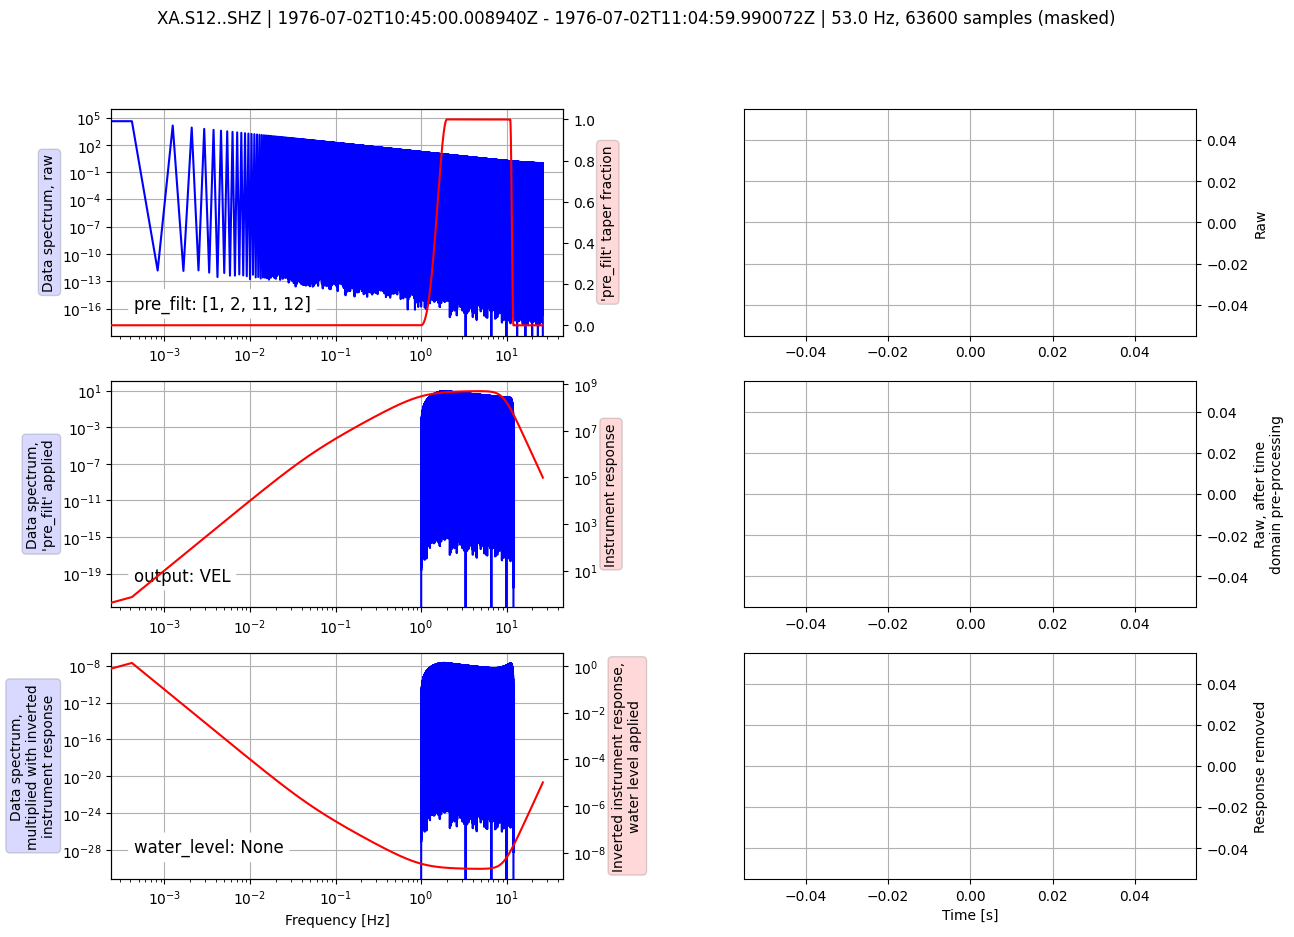

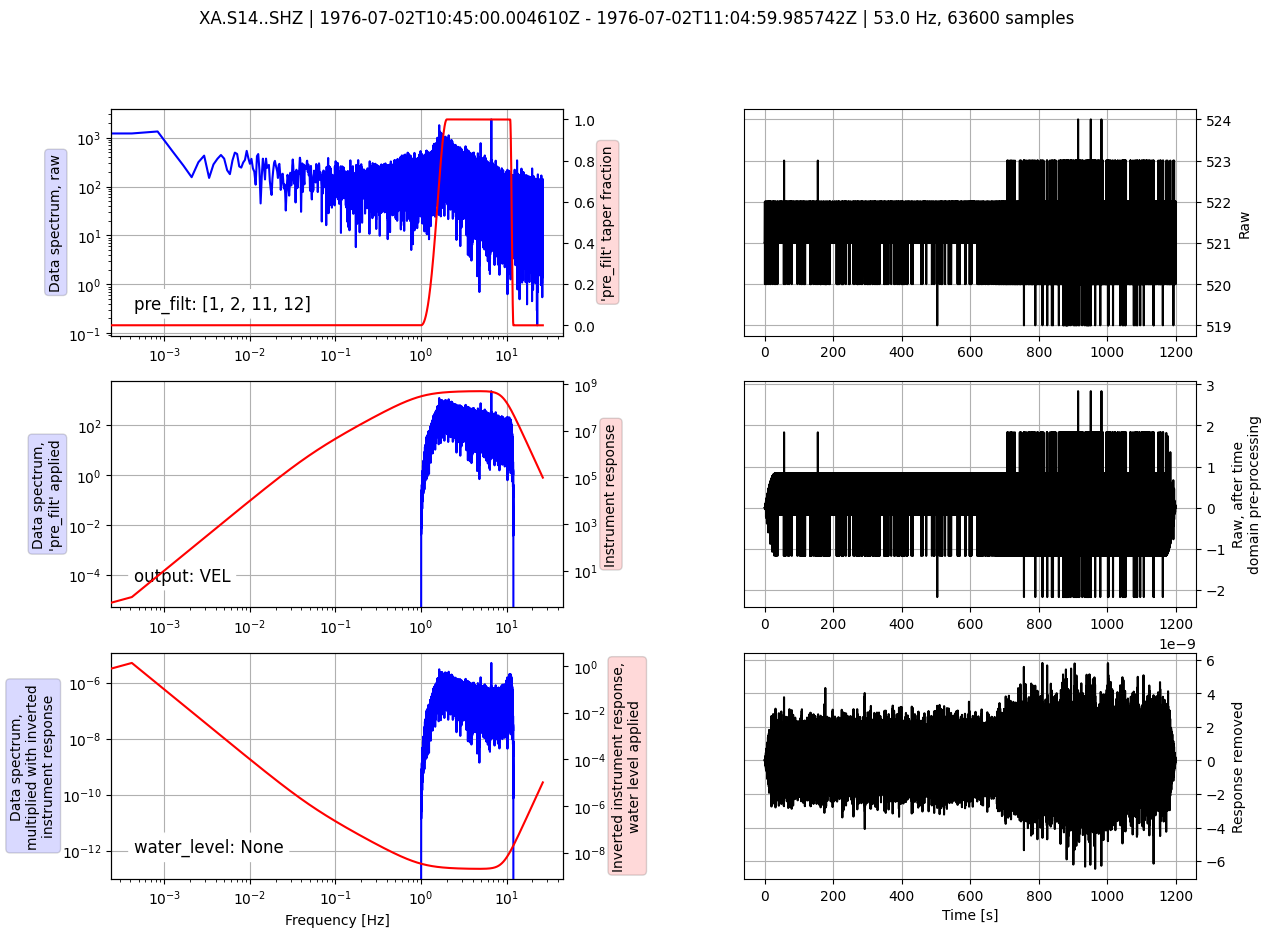

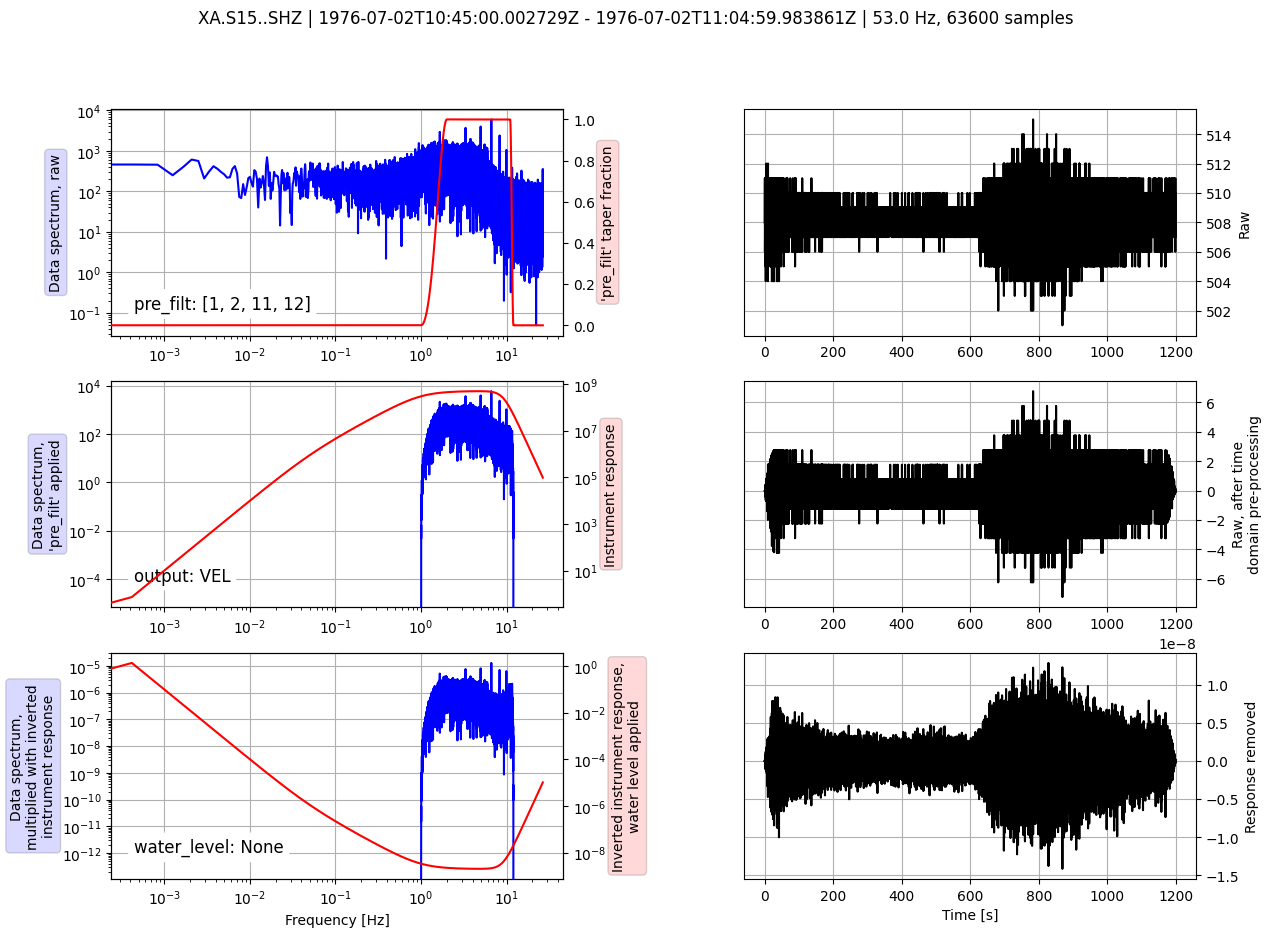

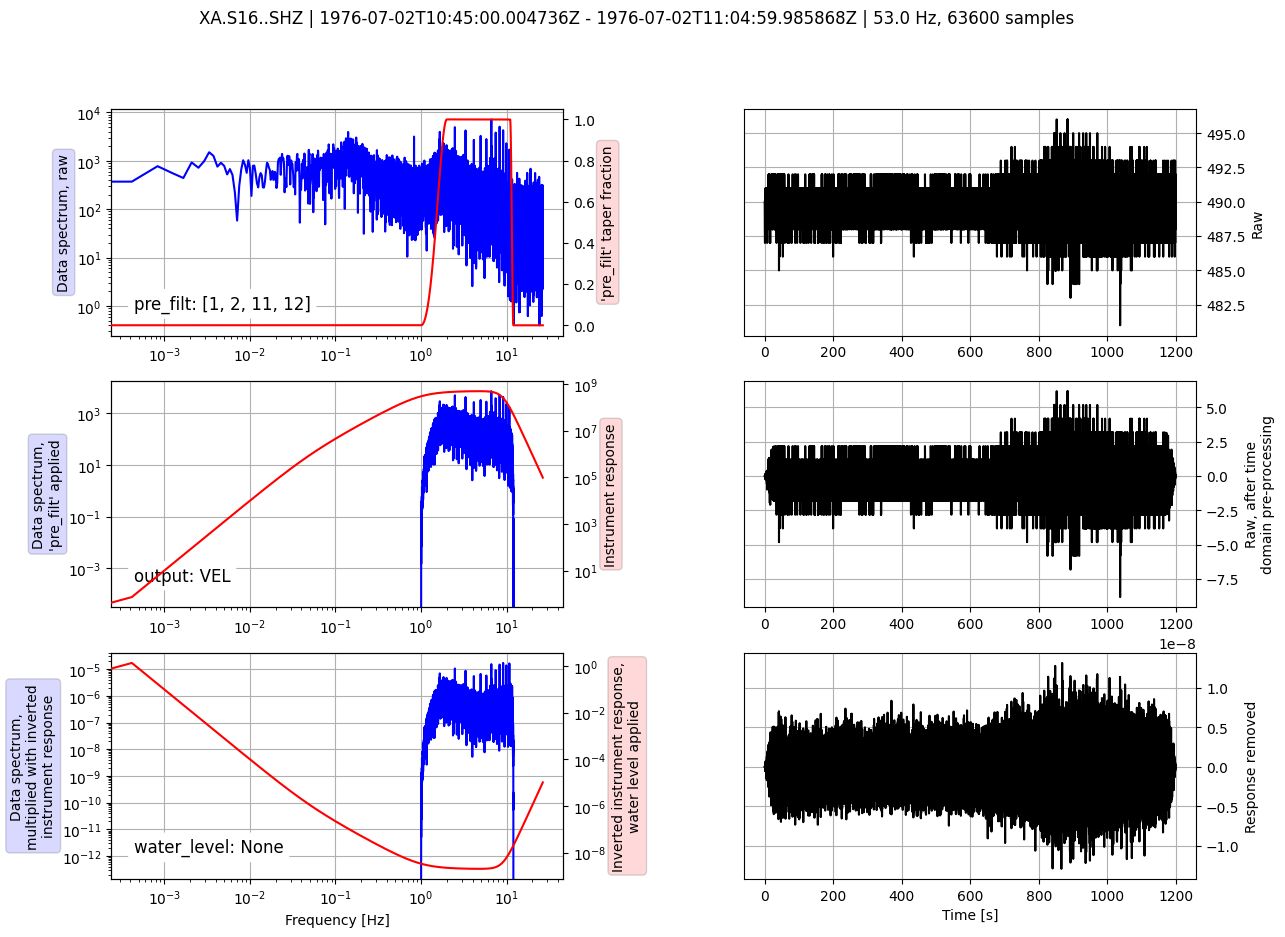

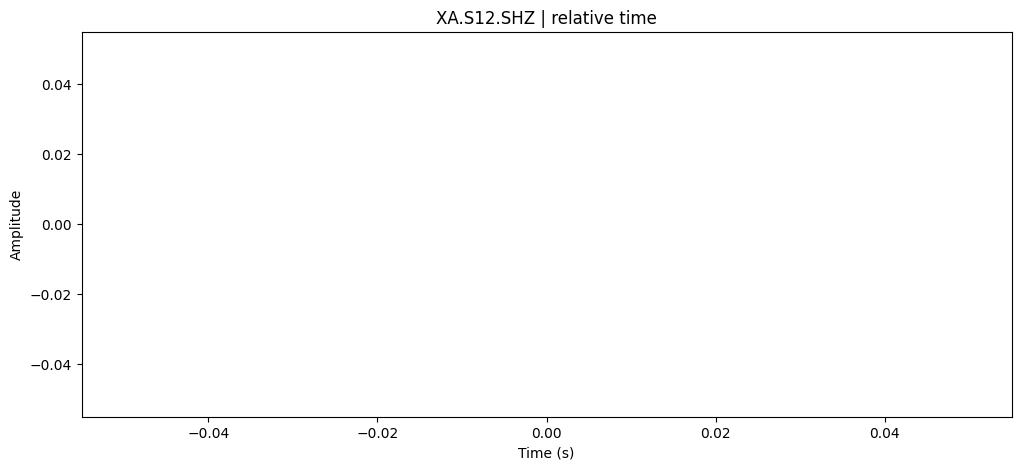

In [ ]:
stream = view_apollo(
        stream=None,
        starttime=UTCDateTime("1976-07-02T10:45:00"),
        endtime=UTCDateTime("1976-07-02T11:05:00") ,
        network="XA",
        station="*",
        channel="SHZ",
        location="*",
        plot_seismogram=True,
        plot_response=True,
    )

st = stream[0].copy()